In [10]:
"""
HEALTHCARE READMISSION ANALYTICS PROJECT
=========================================
Author: Abhishek Saxena
Date: January 2026
Purpose: End-to-end analysis of hospital readmissions using diabetes patient data

This script demonstrates:
1. Data acquisition from public sources
2. Data preprocessing and cleaning
3. Exploratory data analysis
4. Predictive modeling
5. Results visualization and reporting

"""
# ============================================================================
# SECTION 1: ENVIRONMENT SETUP AND LIBRARY IMPORTS
# ============================================================================

# Data manipulation and analysis
import pandas as pd
import numpy as np

#Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    roc_auc_score, 
    roc_curve,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

# Utility libraries
import warnings
import os
from datetime import datetime


# Configuration settings
warnings.filterwarnings('ignore')  # Suppress warnings for cleaner output
pd.set_option('display.max_columns', None)  # Display all columns
pd.set_option('display.max_rows', 100)  # Display up to 100 rows
plt.style.use('seaborn-v0_8-darkgrid')  # Set consistent plot style

# Set random seed for reproducibility
np.random.seed(42)

print("=" * 80)
print("HEALTHCARE READMISSION ANALYTICS PROJECT")
print("=" * 80)
print(f"Execution started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("All libraries imported successfully!\n")


HEALTHCARE READMISSION ANALYTICS PROJECT
Execution started at: 2026-01-22 11:47:33
All libraries imported successfully!



In [11]:
# ============================================================================
# SECTION 2: DATA ACQUISITION
# ============================================================================

"""
We'll download the Diabetes 130-US Hospitals dataset from UCI ML Repository.
This dataset contains 10 years of hospital admission records for diabetes patients.

Dataset characteristics:
- 101,766 hospital admissions
- ~50 features (patient demographics, diagnoses, medications, procedures)
- Target variable: Readmission status
"""

print("\n" + "=" * 80)
print("DATA ACQUISITION")
print("=" * 80)

# Define data URL - UCI Machine Learning Repository
DATA_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00296/dataset_diabetes.zip"

# Alternative manual download instructions
print("""
DATA DOWNLOAD INSTRUCTIONS:
---------------------------
Option 1 (Recommended): Manual Download
1. Visit: https://archive.ics.uci.edu/ml/datasets/diabetes+130-us+hospitals+for+years+1999-2008
2. Click 'Download' to get 'dataset_diabetes.zip'
3. Extract the ZIP file
4. Place 'diabetic_data.csv' in your working directory

Option 2: Direct Download (if accessible)
The script will attempt to download automatically.
""")

# Check if data already exists
data_file = 'diabetes_data/diabetic_data.csv'

if os.path.exists(data_file):
    print(f"✓ Data file '{data_file}' found in current directory.")
else:
    print(f"✗ Data file '{data_file}' not found.")
    print("Please download manually following the instructions above.")
    print("\nFor this tutorial, we'll proceed assuming the file is available.")

# Load the dataset
try:
    print("\nLoading dataset...")
    df_raw = pd.read_csv(data_file)
    print(f"✓ Dataset loaded successfully!")
    print(f"  - Shape: {df_raw.shape[0]:,} rows × {df_raw.shape[1]} columns")
    print(f"  - Memory usage: {df_raw.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
except FileNotFoundError:
    print("\n⚠ ERROR: Data file not found!")
    print("Creating sample instructions for students...")
    print("\nTo continue with this tutorial:")
    print("1. Download the dataset from the UCI repository")
    print("2. Save 'diabetic_data.csv' in this directory")
    print("3. Re-run this script")

 # For demonstration purposes, we'll create a note

# Display basic information about the dataset
print("\n" + "-" * 80)
print("INITIAL DATA PREVIEW")
print("-" * 80)
print("\nFirst 5 rows:")
print(df_raw.head())

print("\n\nDataset Info:")
print(df_raw.info())

print("\n\nBasic Statistics:")
print(df_raw.describe())




DATA ACQUISITION

DATA DOWNLOAD INSTRUCTIONS:
---------------------------
Option 1 (Recommended): Manual Download
1. Visit: https://archive.ics.uci.edu/ml/datasets/diabetes+130-us+hospitals+for+years+1999-2008
2. Click 'Download' to get 'dataset_diabetes.zip'
3. Extract the ZIP file
4. Place 'diabetic_data.csv' in your working directory

Option 2: Direct Download (if accessible)
The script will attempt to download automatically.

✓ Data file 'diabetes_data/diabetic_data.csv' found in current directory.

Loading dataset...
✓ Dataset loaded successfully!
  - Shape: 101,766 rows × 50 columns
  - Memory usage: 192.87 MB

--------------------------------------------------------------------------------
INITIAL DATA PREVIEW
--------------------------------------------------------------------------------

First 5 rows:
   encounter_id  patient_nbr             race  gender      age weight  \
0       2278392      8222157        Caucasian  Female   [0-10)      ?   
1        149190     55629189  



DATA QUALITY ASSESSMENT

1. DUPLICATE RECORDS CHECK
--------------------------------------------------------------------------------
Total duplicate rows: 0


2. MISSING VALUES ANALYSIS
--------------------------------------------------------------------------------

Columns with missing values: 2

       Column  Missing_count  Missing_Percentage
max_glu_serum          96420               94.75
    A1Cresult          84748               83.28


3. PLACEHOLDER VALUES CHECK
--------------------------------------------------------------------------------
Healthcare datasets often use '?' or 'UNknow' as placeholders 
✓ No '?' placeholders found!


4. DATA TYPES SUMMARY
--------------------------------------------------------------------------------
str      37
int64    13
Name: count, dtype: int64


Columns by data type:

int64:
  Count: 13
  Columns: encounter_id, patient_nbr, admission_type_id, discharge_disposition_id, admission_source_id...

str:
  Count: 37
  Columns: race, gender, 

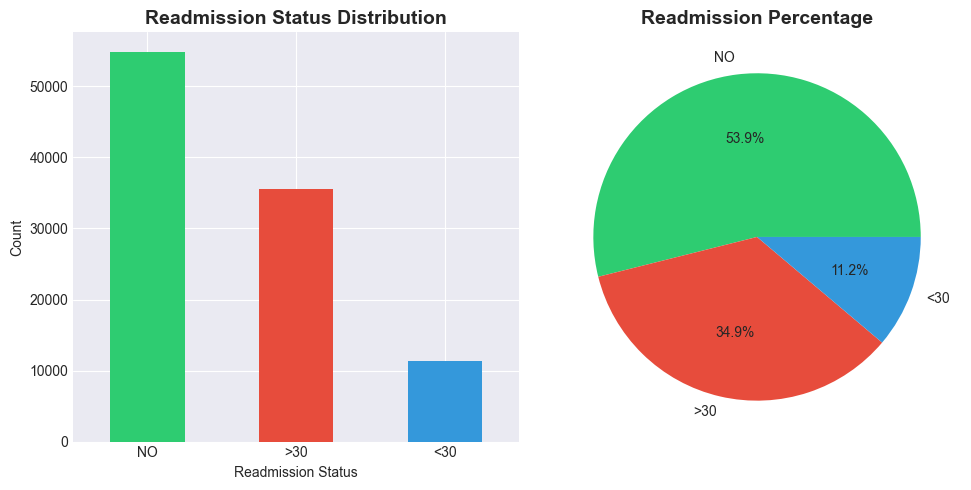

In [15]:
# ============================================================================
# SECTION 3: DATA QUALITY ASSESSMENT
# ============================================================================

"""
Before any analysis, we must understand data quality issues:
1. Missing values
2. Duplicate records
3. Data types
4. Value distributions
5. Outliers

This step is CRITICAL - poor data quality leads to poor insights!
"""

print("\n\n" + "=" * 80)
print("DATA QUALITY ASSESSMENT")
print("=" * 80)

#Create a copy for preprocessing(preserve raw data) 
df = df_raw.copy()

#3.1 Check for duplicate records
print("\n1. DUPLICATE RECORDS CHECK")
print("-" * 80)
duplicates = df.duplicated().sum()
print(f"Total duplicate rows: {duplicates:,}")

if duplicates >0:
    print(f"Percentage of duplicates: {duplicates/len(df)*100:.2f}%")
    #Note: We'll keep duplicates as they represent separate encounters
    print("NOte: In healthcare, duplicate rows may represent separate patient encounters.")
    print("We'll retain them for now and invertigate further.")

#3.2 Missing values analysis
print("\n\n2. MISSING VALUES ANALYSIS")
print("-" * 80)

#Calculate Missing values
missing_data = pd.DataFrame({
    'Column': df.columns,
    'Missing_count': df.isnull().sum(),
    'Missing_Percentage':(df.isnull().sum() / len(df) * 100).round(2)
})
missing_data = missing_data[
    missing_data['Missing_count'] > 0
].sort_values(
    'Missing_Percentage',
    ascending=False
)


if len(missing_data) > 0:
    print(f"\nColumns with missing values: {len(missing_data)}")
    print("\n" + missing_data.to_string(index=False))
else:
    print("✓ No missing values detected in the dataset!")

#3.3 Check for placeholder values(common in healthcare data)
print("\n\n3. PLACEHOLDER VALUES CHECK")
print ("-" * 80)
print("Healthcare datasets often use '?' or 'UNknow' as placeholders ")

# Count '?' occurrences in each column
placeholder_counts = {}
for col in df.columns:
    if df[col].dtype == 'object':  # Only check string columns
        placeholder_count = (df[col] == '?').sum()
        if placeholder_count > 0:
            placeholder_counts[col] = {
                'count': placeholder_count,
                'percentage': round(placeholder_count / len(df) * 100, 2)
            }

if placeholder_counts:
    print(f"\nColumns with '?' placeholders: {len(placeholder_counts)}")
    for col, stats in sorted(placeholder_counts.items(), 
                            key=lambda x: x[1]['percentage'], 
                            reverse=True):
        print(f"  - {col}: {stats['count']:,} ({stats['percentage']}%)")
else:
    print("✓ No '?' placeholders found!")

# 3.4 Data types examination
print("\n\n4. DATA TYPES SUMMARY")
print("-" * 80)
dtype_summary = df.dtypes.value_counts()
print(dtype_summary)

print("\n\nColumns by data type:")
for dtype in df.dtypes.unique():
    cols = df.select_dtypes(include=[dtype]).columns.tolist()
    print(f"\n{dtype}:")
    print(f"  Count: {len(cols)}")
    print(f"  Columns: {', '.join(cols[:5])}{'...' if len(cols) > 5 else ''}")

# 3.5 Target variable distribution
print("\n\n5. TARGET VARIABLE ANALYSIS")
print("-" * 80)
print("Our target variable is 'readmitted' - indicating if patient was readmitted.")

if 'readmitted' in df.columns:
    print("\nReadmission status distribution:")
    readmit_dist = df['readmitted'].value_counts()
    print(readmit_dist)
    print("\nPercentages:")
    print((readmit_dist / len(df) * 100).round(2))
    
    # Visualize target distribution
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    readmit_dist.plot(kind='bar', color=['#2ecc71', '#e74c3c', '#3498db'])
    plt.title('Readmission Status Distribution', fontsize=14, fontweight='bold')
    plt.xlabel('Readmission Status')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    
    plt.subplot(1, 2, 2)
    plt.pie(readmit_dist.values, labels=readmit_dist.index, autopct='%1.1f%%',
            colors=['#2ecc71', '#e74c3c', '#3498db'])
    plt.title('Readmission Percentage', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('01_target_distribution.png', dpi=300, bbox_inches='tight')
    print("\n✓ Visualization saved: '01_target_distribution.png'")
    plt.show()
